<a href="https://colab.research.google.com/github/jaotheboss/ESG-Disclosure-Analysis/blob/preprocessing-tweaks/Main_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Main Analysis for DSA4264

**Task**:
Explore the relationship between a firm's environmental disclosure and financial performance. 


**Tasks**:
1. Extract out the text data of the firms that have available financial metrics
2. Filter out the environmental disclosures (sentence that contains the keywords or n-grams) from the text data
3. Concatenate all the sentences from each document and have each document form the observations of a corpus
4. Perform LDA or STM on the corpus
5. Analyse the results:
    
    - Between rating 1 and 5
    - Across the years
    - Both

## Setting up the modules and functions

In [56]:
# setting up the work directory
import os 
os.chdir('/content/drive/My Drive/School/NUS/Year 4 Sem 1/DSA4264/(TSX) Toronto')

!pip install pyLDAvis
!pip install pdfplumber

import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import re
import spacy
nlp = spacy.load('en_core_web_sm')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation # LDA
import pyLDAvis
pyLDAvis.enable_notebook()
import pyLDAvis.sklearn
import pdfplumber
import multiprocessing as mp

In [77]:
# defining functions
def _PREPROCESS(text, min_char_len = 3, max_char_len = 15):
    """
    Function:     Preprocesses and cleans text
                    
    Input:        Text array
    
    Returns:      A column of processed text
    """
    contractions = {
            "ain't": "am not / are not",
            "aren't": "are not / am not",
            "can't": "cannot",
            "can't've": "cannot have",
            "'cause": "because",
            "could've": "could have",
            "couldn't": "could not",
            "couldn't've": "could not have",
            "didn't": "did not",
            "doesn't": "does not",
            "don't": "do not",
            "hadn't": "had not",
            "hadn't've": "had not have",
            "hasn't": "has not",
            "haven't": "have not",
            "he'd": "he had / he would",
            "he'd've": "he would have",
            "he'll": "he shall / he will",
            "he'll've": "he shall have / he will have",
            "he's": "he has / he is",
            "how'd": "how did",
            "how'd'y": "how do you",
            "how'll": "how will",
            "how's": "how has / how is",
            "i'd": "I had / I would",
            "i'd've": "I would have",
            "i'll": "I shall / I will",
            "i'll've": "I shall have / I will have",
            "i'm": "I am",
            "i've": "I have",
            "isn't": "is not",
            "it'd": "it had / it would",
            "it'd've": "it would have",
            "it'll": "it shall / it will",
            "it'll've": "it shall have / it will have",
            "it's": "it has / it is",
            "let's": "let us",
            "ma'am": "madam",
            "mayn't": "may not",
            "might've": "might have",
            "mightn't": "might not",
            "mightn't've": "might not have",
            "must've": "must have",
            "mustn't": "must not",
            "mustn't've": "must not have",
            "needn't": "need not",
            "needn't've": "need not have",
            "o'clock": "of the clock",
            "oughtn't": "ought not",
            "oughtn't've": "ought not have",
            "shan't": "shall not",
            "sha'n't": "shall not",
            "shan't've": "shall not have",
            "she'd": "she had / she would",
            "she'd've": "she would have",
            "she'll": "she shall / she will",
            "she'll've": "she shall have / she will have",
            "she's": "she has / she is",
            "should've": "should have",
            "shouldn't": "should not",
            "shouldn't've": "should not have",
            "so've": "so have",
            "so's": "so as / so is",
            "that'd": "that would / that had",
            "that'd've": "that would have",
            "that's": "that has / that is",
            "there'd": "there had / there would",
            "there'd've": "there would have",
            "there's": "there has / there is",
            "they'd": "they had / they would",
            "they'd've": "they would have",
            "they'll": "they shall / they will",
            "they'll've": "they shall have / they will have",
            "they're": "they are",
            "they've": "they have",
            "to've": "to have",
            "wasn't": "was not",
            "we'd": "we had / we would",
            "we'd've": "we would have",
            "we'll": "we will",
            "we'll've": "we will have",
            "we're": "we are",
            "we've": "we have",
            "weren't": "were not",
            "what'll": "what shall / what will",
            "what'll've": "what shall have / what will have",
            "what're": "what are",
            "what's": "what has / what is",
            "what've": "what have",
            "when's": "when has / when is",
            "when've": "when have",
            "where'd": "where did",
            "where's": "where has / where is",
            "where've": "where have",
            "who'll": "who shall / who will",
            "who'll've": "who shall have / who will have",
            "who's": "who has / who is",
            "who've": "who have",
            "why's": "why has / why is",
            "why've": "why have",
            "will've": "will have",
            "won't": "will not",
            "won't've": "will not have",
            "would've": "would have",
            "wouldn't": "would not",
            "wouldn't've": "would not have",
            "y'all": "you all",
            "y'all'd": "you all would",
            "y'all'd've": "you all would have",
            "y'all're": "you all are",
            "y'all've": "you all have",
            "you'd": "you had / you would",
            "you'd've": "you would have",
            "you'll": "you shall / you will",
            "you'll've": "you shall have / you will have",
            "you're": "you are",
            "you've": "you have"}

    def contract(text):
        for word in text.split():
            if word.lower() in contractions:
                text = text.replace(word, contractions[word.lower()])
        return text
    
    def preprocess(text):
        # throw away numbers
        text = re.sub(r"@\S+|https?:\S+|http?:\S|[^A-Za-z]+", ' ', str(text).lower()).strip() 
        doc = nlp(text)
        text = [token.lemma_ for token in doc if token.is_stop == False and len(token) >= min_char_len and len(token) <= max_char_len]
        new_text = ' '.join(text)
        return new_text
       
    text = text.apply(contract).apply(preprocess)
    return text

def extract_pdf_text(file_name, min_sent_len = 10):
    doc = []
    with pdfplumber.open(file_name) as pdf:
        pages = pdf.pages
        for i in tqdm(pages):
            page = i.extract_text()
            doc.extend([sentence.string for sentence in nlp(page).sents if len(sentence) >= min_sent_len])
    doc = _PREPROCESS(pd.Series(doc))
    return doc

def get_top_k(df, vectorizer, k = 10):
       """get top k occuring words"""
       vectorizer.fit(df)
       counts = pd.DataFrame(vectorizer.transform(df).toarray())
       counts.columns = vectorizer.get_feature_names()
       counts = counts.apply(sum).sort_values(ascending = False)[:k]
       sns.barplot(x = counts.values, y = counts.index)

## Preprocessing

In [34]:
# getting the file names
metadata = pd.read_csv('clustered_files_cleaned.csv')
def quantiles(arr):
    result = []
    quads = [np.quantile(arr, 0.25*i) for i in range(1, 4)]
    for i in arr:
        if i <= quads[0]:
            result.append(1)
        elif i <= quads[1]:
            result.append(2)
        elif i <= quads[2]:
            result.append(3)
        else:
            result.append(4)
    return result
metadata['rating_quarters'] = quantiles(metadata.earnings)

We will only be looking at the top and bottom 25% of the ratings. This is ensure that there is a discernible distinction in performance metric. By doing so, we hope to more clearly distinguish the aspects of an environmental disclosure that correlates with the financial metric

In [70]:
# filtering out by quarters
filtered_metadata = metadata[['finalfilename', 'fileyear', 'rating_quarters']]
filtered_metadata = filtered_metadata.loc[metadata.rating_quarters != 2, :]  
filtered_metadata = filtered_metadata.loc[metadata.rating_quarters != 3, :]
filtered_metadata.reset_index(drop = True, inplace = True)
filtered_metadata

,finalfilename,fileyear,rating_quarters
0,TSX_7376__Absolute Software Corp___Active____(...,2018,4
1,TSX_7319__AcuityAds Holdings Inc___Active____(...,2018,1
2,TSX_1041__Alacer Gold Corp___Active____(2018-1...,2018,4
3,TSX_1041__Alexco Resource Corp___Active____(20...,2018,1
4,TSX_4449__Algoma Central Corp___Active____(201...,2018,1
...,...,...,...
236,TSX_3533__Total Energy Services Inc___Active__...,2015,4
237,TSX_1031__Trevali Mining Corp___Active____(201...,2015,4
238,TSX_6531__Wall Financial Corp___Active____(201...,2015,4
239,TSX_1021__Wallbridge Mining Company Ltd___Acti...,2015,4


In [71]:
# extracting out the text data
pool = mp.Pool()
dirty_corpus = pool.map(extract_pdf_text, filtered_metadata.finalfilename)
pool.close()

100%|██████████| 41/41 [00:08<00:00,  4.63it/s]


In [117]:
# filtering the corpus with environmental keywords
# https://quantaloop.io/the-language-of-sustainability-top-101-green-initiative-keywords/
e_sus_keywords = {'global', 'warming', 'water', 'air', 'environmental', 'nature', 'earth', 'solar', 'energy', 'green', 'recycling', 'pollution', 'energy', 'sustain'}
def filter_keyword(dirty_doc):
    filtered_doc = []
    for sentence in dirty_doc:
        # ignore short sentences
        if len(sentence.split()) <= 3:
            continue
        else:
            if e_sus_keywords.intersection(set(sentence.split())):
                filtered_doc.append(sentence)
                break
    return ' '.join(filtered_doc)
pool = mp.Pool()
filtered_corpus = pool.map(filter_keyword, dirty_corpus)
pool.close()

**PAUSE**

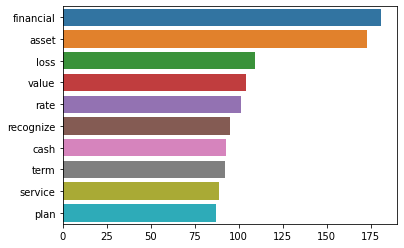

In [ ]:
count_vectorizer = CountVectorizer(ngram_range = (1, 3),
                                   max_df = 0.8,
                                   min_df = 0.05,
                                   max_features = None)

def get_top_k(df, vectorizer, k = 10):
       """get top k occuring words"""
       vectorizer.fit(df)
       counts = pd.DataFrame(vectorizer.transform(df).toarray())
       counts.columns = vectorizer.get_feature_names()
       counts = counts.apply(sum).sort_values(ascending = False)[:k]
       sns.barplot(x = counts.values, y = counts.index)

get_top_k(doc_filtered, count_vectorizer)

## Performing LDA

To extract topics from each document within the corpus

In [ ]:
# Training the LDA model
tfidf_vectorizer = TfidfVectorizer(ngram_range = (1, 3),
                                   max_df = 0.8,
                                   min_df = 0.05,
                                   max_features = None)
doc_tfidf = tfidf_vectorizer.fit_transform(doc_filtered)
lda = LatentDirichletAllocation(n_components = 5, 
                                random_state = 69)
lda.fit(doc_tfidf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=69, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [ ]:
# LDA visualisation
pyLDAvis.sklearn.prepare(lda, doc_tfidf, tfidf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.136427  0.178978       1        1  25.023800
3      0.225695 -0.211442       2        1  21.926918
0      0.133729 -0.041781       3        1  19.705861
2     -0.138793  0.253826       4        1  17.942647
4     -0.357059 -0.179581       5        1  15.400774, topic_info=          Term       Freq      Total Category  logprob  loglift
16    interest  48.000000  48.000000  Default  30.0000  30.0000
13      follow  42.000000  42.000000  Default  29.0000  29.0000
29        term  47.000000  47.000000  Default  28.0000  28.0000
4     canadian  41.000000  41.000000  Default  27.0000  27.0000
28  subsidiary  37.000000  37.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
4     canadian   0.226498  41.321881   Topic5  -6.6744  -3.3357
18        loss   0.226987  42.671102   Topic5  -6.6722  -3.3656
29        term   0.228309  47.219111   Topic5  -6.6664  -3.4611
12   financial   0.228398  64.352987   Topic5  -6.6660  -3.7703
1        asset   0.229389  65.811337   Topic5  -6.6617  -3.7884

[185 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
0         1  0.974203      acquisition
1         1  0.243119            asset
1         2  0.486238            asset
1         3  0.212729            asset
1         4  0.060780            asset
2         1  0.219815             base
2         2  0.753653             base
3         3  0.989425          benefit
4         4  0.992210         canadian
5         4  0.962884  canadian dollar
6         2  0.980949             cash
7         1  0.282016             cost
7         3  0.366620             cost
7         4  0.338419             cost
8         4  0.970782           dollar
9         4  0.969371          expense
10        1  0.980216             fair
11        1  0.970693       fair value
12        1  0.839122        financial
12        4  0.139854        financial
13        5  0.990005           follow
14        1  0.959962          include
15        1  0.978086       instrument
16        5  0.980613         interest
17        1  0.151539        liability
17        2  0.181846        liability
17        3  0.666769        liability
18        2  0.984273             loss
19        5  0.991668       management
20        3  0.987563              net
21        3  0.080176             plan
21        4  0.661450             plan
21        5  0.260571             plan
22        2  0.988099           profit
23        2  0.982350             rate
24        1  0.111134        recognize
24        2  0.333403        recognize
24        3  0.527888        recognize
24        4  0.027784        recognize
25        2  0.986431             risk
26        3  0.987448          service
27        1  0.981510        statement
28        5  0.971611       subsidiary
29        3  0.974182             term
30        1  0.970010            value, R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 1, 3, 5])

In [ ]:
# Showing the words for each topic
n_words_to_show = 8
display_topics(lda, tfidf_vectorizer.get_feature_names(), n_words_to_show)

Topic 0: service acquisition include rate cost liability asset term
Topic 1: share canadian dollar year canadian dollar base management plan
Topic 2: asset loss recognize net benefit profit liability follow
Topic 3: financial term interest expense statement corporation subsidiary risk
Topic 4: corporation august cash value plan end fair year


In [ ]:
ticker = yf.Ticker('KO')
temp = pd.DataFrame.transpose(ticker.sustainability)
temp['company_ticker'] = str(ticker.ticker)

{'adult': False,
 'alcoholic': False,
 'animalTesting': True,
 'catholic': False,
 'coal': False,
 'controversialWeapons': False,
 'environmentPercentile': None,
 'environmentScore': 8.38,
 'esgPerformance': 'AVG_PERF',
 'furLeather': False,
 'gambling': False,
 'gmo': False,
 'governancePercentile': None,
 'governanceScore': 5.05,
 'highestControversy': 3,
 'militaryContract': False,
 'nuclear': False,
 'palmOil': False,
 'peerCount': 94,
 'peerGroup': 'Food Products',
 'percentile': 35.4,
 'pesticides': False,
 'smallArms': False,
 'socialPercentile': None,
 'socialScore': 10.81,
 'tobacco': False,
 'totalEsg': 24.24}